# Import

In [1]:
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import sklearn.metrics.cluster as cluster_metrics
import numpy as np
from os import name
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
from sklearn.cluster import AgglomerativeClustering, KMeans
import torch
from torch import nn
from torchsummary import summary
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from IPython.display import display
import matplotlib.pyplot as plt

# Import from main library TriQlet

from triqlet.quantum.models import QuantumSamplerModel
from triqlet.quantum.layers import PoolingLayer, RealAmplitudeLayer, SwapTestLayer, EncoderLayer, QuantumSequential
from triqlet.triplet.datasets import TripletImageDataset
from triqlet.triplet.embedders import CNNAnglesEmbeddingNet
from triqlet.triplet.losses import TripletLoss
from triqlet.triplet.models import TripletNet
from triqlet.triplet.distances import EuclideanDistance
from triqlet.utils import triple_train, color, automatic_backend_chooser, embed



# Encoding e Utility

Training device selection

In [2]:
device = automatic_backend_chooser()

CUDA NOT Available
MPS Available
Using MPS Acceleration


Helper functions for clustring evaluation metrics

In [3]:
def purity_score(y_true, y_pred):
    contingency_matrix = cluster_metrics.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def evaluate_clustering(X, pred_y, true_y):
    print(f"{'Silhouette:':15s}{silhouette_score(X, pred_y):2.3f}")
    print(f"{'Purity:':15s}{purity_score(true_y, pred_y):2.3f}")

def evaluate_clustering_table(X, pred_y, true_y):
    return silhouette_score(X, pred_y), purity_score(true_y, pred_y)

# MNIST / FashionMNIST Images Dataset

In [4]:
NUM_CLASSES = 10
SAMPLER_PER_CLASS = 30
INITIAL_TRAINING_SAMPLES = NUM_CLASSES * SAMPLER_PER_CLASS
LOAD_FASHION = True
RANDOM_STATE = 42

Ensuring test and training set have a balanced number of classes

In [5]:
MNIST_base_transform = transforms.Compose([
transforms.ToTensor()
])

if LOAD_FASHION:
    MNIST_dataset_train = datasets.FashionMNIST(root="./FashionMNIST", train=True, download=True, transform=MNIST_base_transform)
    MNIST_dataset_test = datasets.FashionMNIST(root="./FashionMNIST", train=False, download=True, transform=MNIST_base_transform)
else:
    MNIST_dataset_train = datasets.MNIST(root="./MNIST", train=True, download=True, transform=MNIST_base_transform)
    MNIST_dataset_test = datasets.MNIST(root="./MNIST", train=False, download=True, transform=MNIST_base_transform)


index01 = MNIST_dataset_train.targets < NUM_CLASSES
MNIST_dataset_train.data = MNIST_dataset_train.data[index01]
MNIST_dataset_train.targets = MNIST_dataset_train.targets[index01]

index01_test = MNIST_dataset_test.targets < NUM_CLASSES
MNIST_dataset_test.data = MNIST_dataset_test.data[index01_test]
MNIST_dataset_test.targets = MNIST_dataset_test.targets[index01_test]



print(f"FULL DATASET INFO")
print(f"Image shape            : {MNIST_dataset_train.data.shape}")
print(f"Total training samples : {len(MNIST_dataset_train)}")
print(f"Total test     samples : {len(MNIST_dataset_test)}")
print("")

init_train_data, _, init_train_target, _ = train_test_split(
    range(len(MNIST_dataset_train)), 
    MNIST_dataset_train.targets,
    random_state=RANDOM_STATE,
    stratify=MNIST_dataset_train.targets,
    test_size=len(MNIST_dataset_train)- INITIAL_TRAINING_SAMPLES)


X = MNIST_dataset_train.data[init_train_data].numpy().astype("float32") / 255
y = MNIST_dataset_train.targets[init_train_data].numpy().astype("float32") 

print("TRAINING DATA INFO")
print(f"Image shape            : {X.shape}")
print(f"Total training samples : {len(X)}")
print("")

X_test = MNIST_dataset_test.data.numpy().astype("float32") / 255
y_test = MNIST_dataset_test.targets.numpy().astype("float32")

print("TESTING DATA INFO")
print(f"Image shape            : {X_test.shape}")
print(f"Total training samples : {len(X_test)}")
print("")

FULL DATASET INFO
Image shape            : torch.Size([60000, 28, 28])
Total training samples : 60000
Total test     samples : 10000

TRAINING DATA INFO
Image shape            : (300, 28, 28)
Total training samples : 300

TESTING DATA INFO
Image shape            : (10000, 28, 28)
Total training samples : 10000



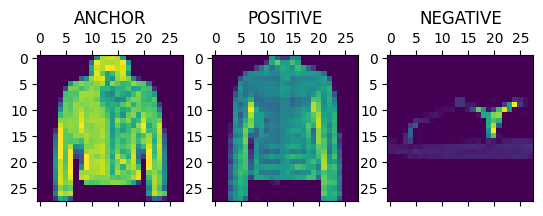

In [6]:
t = TripletImageDataset(X, y, NUM_CLASSES, transforms.ToTensor())

anchor, pos, neg = t[0]
fig, axs = plt.subplots(1,3)

axs[0].set_title("ANCHOR")
axs[0].matshow(anchor.squeeze(0))

axs[1].set_title("POSITIVE")
axs[1].matshow(pos.squeeze(0))

axs[2].set_title("NEGATIVE")
axs[2].matshow(neg.squeeze(0))

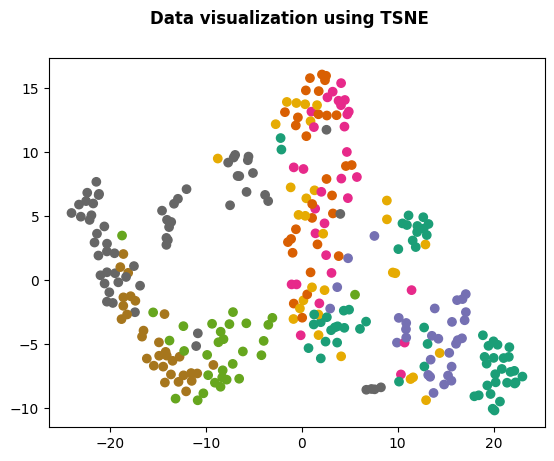

In [7]:
reduction_model = TSNE(n_components=2, perplexity=30, random_state=42)

vis_x = reduction_model.fit_transform(t.get_flatten(), t.target)

fig, ax = plt.subplots()
fig.suptitle("Data visualization using TSNE", weight="bold")
ax.scatter(vis_x[:,0], vis_x[:,1], c=t.target, cmap='Dark2')

# Quantum Neural Network Circuits using TriQlet

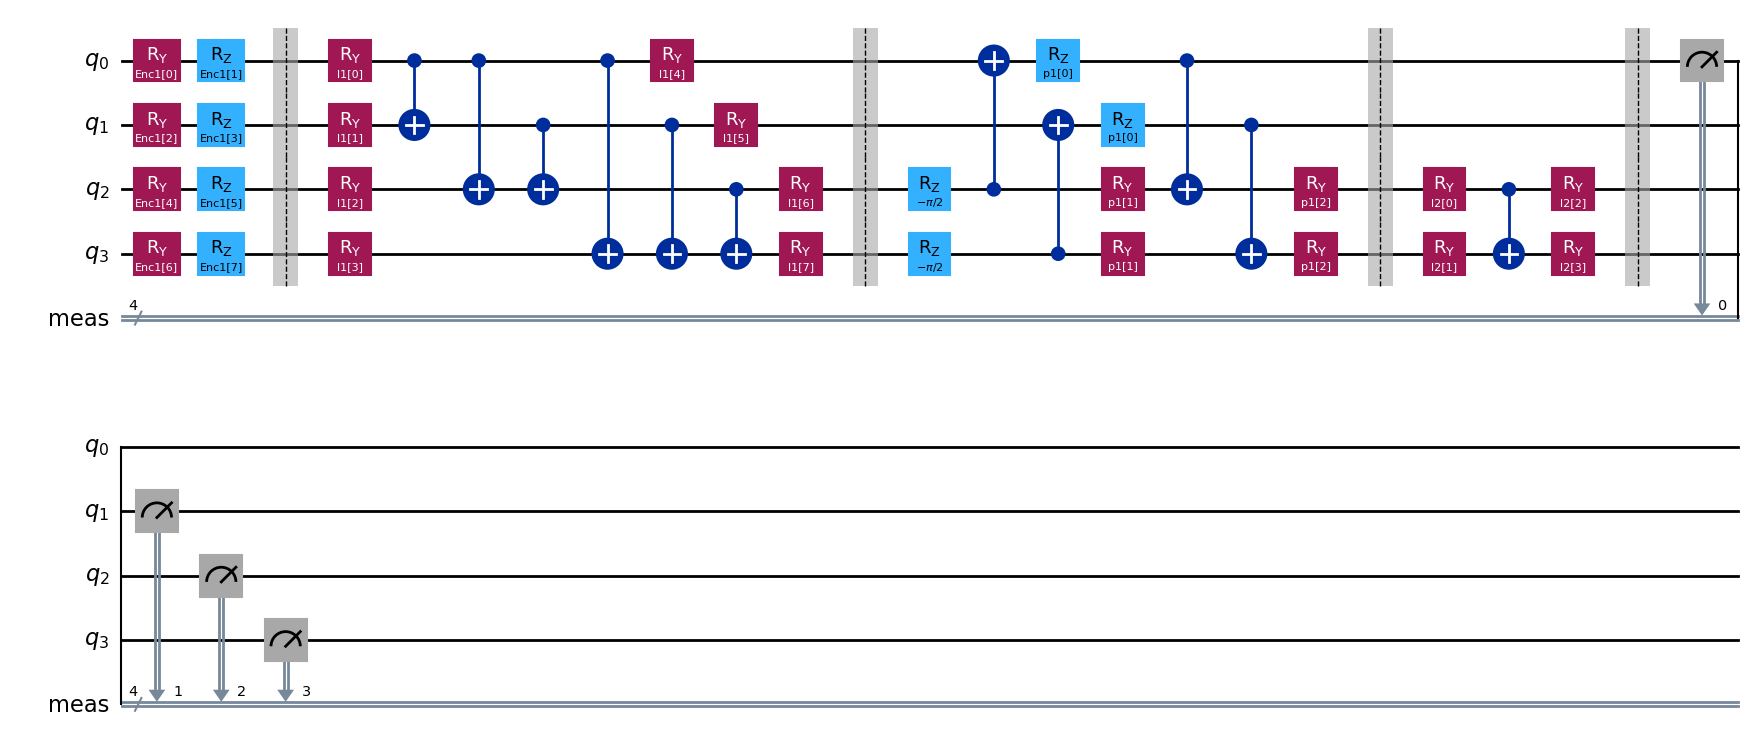

In [8]:
YZ_CNN_FullMeas = QuantumSamplerModel(
    circ_qubits = 4,

    encoder =EncoderLayer(
        circ_qubits=4,
        apply_qubits=[0,1,2,3],
        n_features=8,
        param_prefix="Enc1",
        encoder_type="yz",
        barrier=True
    ),

    ansatz = QuantumSequential(
        RealAmplitudeLayer(4, [0,1,2,3], "full", 1, "l1", "L1", True),
        PoolingLayer(4, [0,1], [2,3], "p1", "Pool", True),
        RealAmplitudeLayer(4, [2,3], "full", 1, "l2", "L2", True)
    ),
    
    shots=1000,
    measurement=[0,1,2,3]

)

YZ_CNN_FullMeas.draw(decompose=True)

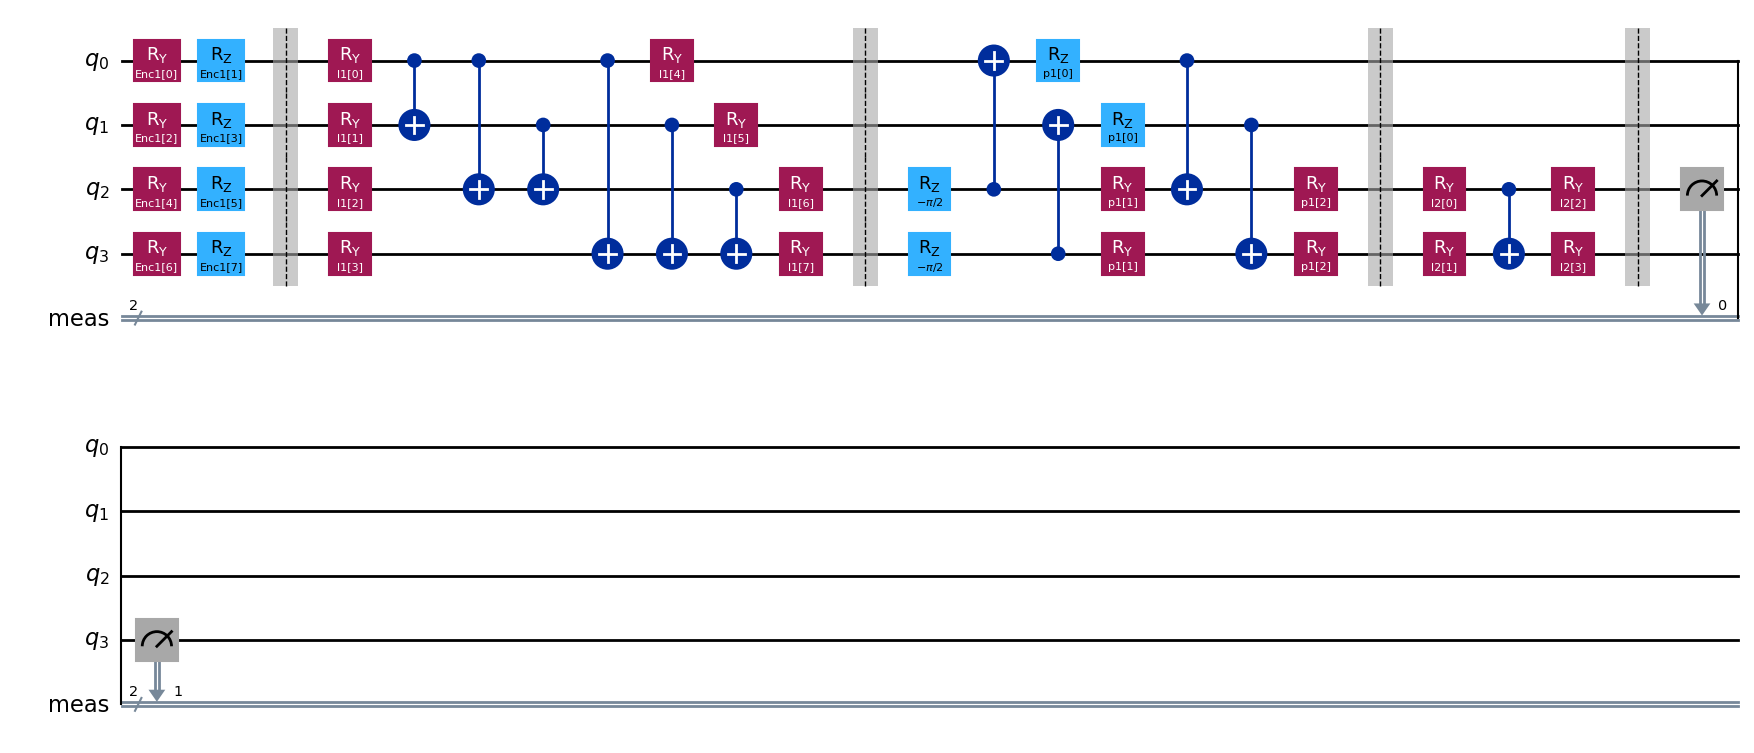

In [9]:
YZ_CNN_PoolMeas = QuantumSamplerModel(
    circ_qubits = 4,

    encoder =EncoderLayer(
        circ_qubits=4,
        apply_qubits=[0,1,2,3],
        n_features=8,
        param_prefix="Enc1",
        encoder_type="yz",
        barrier=True
    ),

    ansatz = QuantumSequential(
        RealAmplitudeLayer(4, [0,1,2,3], "full", 1, "l1", "L1", True),
        PoolingLayer(4, [0,1], [2,3], "p1", "Pool", True),
        RealAmplitudeLayer(4, [2,3], "full", 1, "l2", "L2", True)
    ),
    
    shots=1000,
    measurement=[2,3]

)

YZ_CNN_PoolMeas.draw(decompose=True)

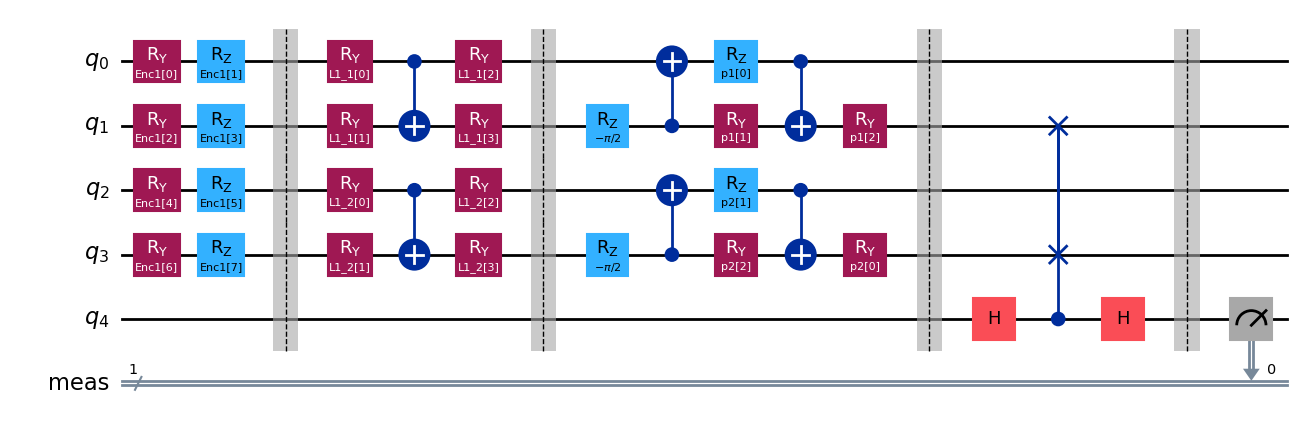

In [10]:
YZ_Pool_Swap = QuantumSamplerModel(
    circ_qubits = 5,

    encoder =EncoderLayer(
        circ_qubits=5,
        apply_qubits=[0,1,2,3],
        n_features=8,
        param_prefix="Enc1",
        encoder_type="yz",
        barrier=True
    ),

    ansatz = QuantumSequential(
        RealAmplitudeLayer(5, [0,1], "full", 1, "L1_1", "L1_1", False),
        RealAmplitudeLayer(5, [2,3], "full", 1, "L1_2", "L1_2", True),
        PoolingLayer(5, [0], [1], "p1", "P1", False),
        PoolingLayer(5, [2], [3], "p2", "P2", True),
        SwapTestLayer(5, [1], [3], 4, "Swap", True)
    ),
    
    shots=1000,
    measurement=[4]

)

YZ_Pool_Swap.draw(decompose=True)

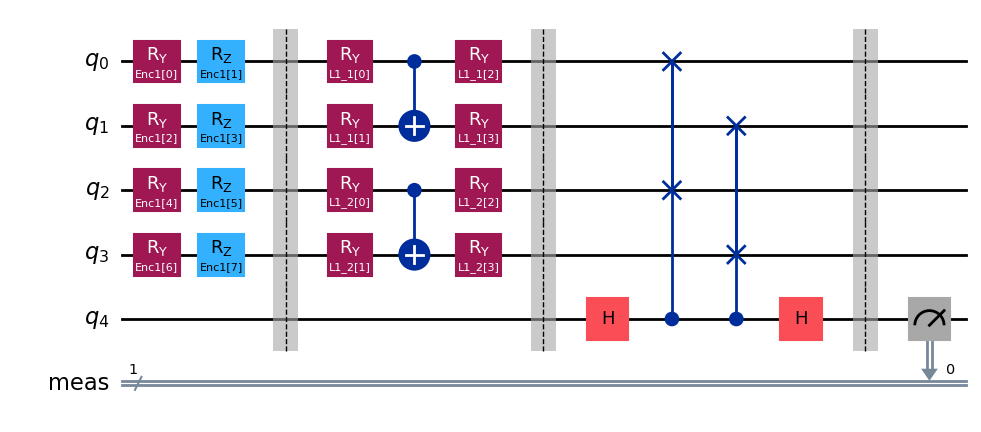

In [11]:
YZ_Swap = QuantumSamplerModel(
    circ_qubits = 5,

    encoder =EncoderLayer(
        circ_qubits=5,
        apply_qubits=[0,1,2,3],
        n_features=8,
        param_prefix="Enc1",
        encoder_type="yz",
        barrier=True
    ),

    ansatz = QuantumSequential(
        RealAmplitudeLayer(5, [0,1], "full", 1, "L1_1", "L1_1", False),
        RealAmplitudeLayer(5, [2,3], "full", 1, "L1_2", "L1_2", True),
        SwapTestLayer(5, [0,1], [2,3], 4, "Swap", True)
    ),
    
    shots=1000,
    measurement=[4]

)

YZ_Swap.draw(decompose=True)

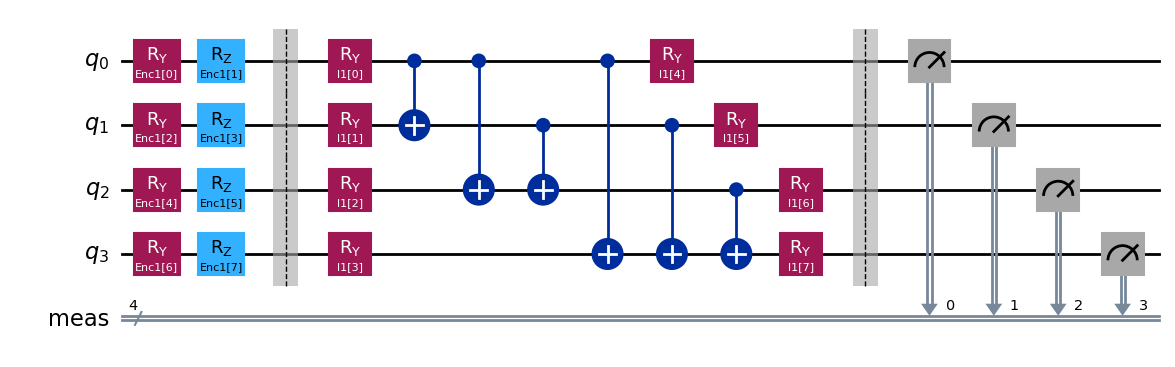

In [12]:
YZ_OnlyReal = QuantumSamplerModel(
    circ_qubits = 4,

    encoder =EncoderLayer(
        circ_qubits=4,
        apply_qubits=[0,1,2,3],
        n_features=8,
        param_prefix="Enc1",
        encoder_type="yz",
        barrier=True
    ),

    ansatz = QuantumSequential(
        RealAmplitudeLayer(4, [0,1,2,3], "full", 1, "l1", "L1", True)
    ),
    
    shots=1000,
    measurement=[0,1,2,3]

)

YZ_OnlyReal.draw(decompose=True)

# Classical SiameseNetworks using TriQlet

In [9]:
summary(CNNAnglesEmbeddingNet(4).to(device if torch.cuda.is_available() else "cpu"), input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
              ReLU-2           [-1, 32, 24, 24]               0
            Conv2d-3           [-1, 32, 20, 20]          25,632
         MaxPool2d-4           [-1, 32, 10, 10]               0
              ReLU-5           [-1, 32, 10, 10]               0
            Conv2d-6             [-1, 64, 6, 6]          51,264
         MaxPool2d-7             [-1, 64, 3, 3]               0
              ReLU-8             [-1, 64, 3, 3]               0
           Flatten-9                  [-1, 576]               0
           Linear-10                  [-1, 120]          69,240
             ReLU-11                  [-1, 120]               0
           Linear-12                    [-1, 4]             484
          Sigmoid-13                    [-1, 4]               0
   RotationScaler-14                   

In [10]:
distance_model = TripletNet(
    nn.Sequential(
        CNNAnglesEmbeddingNet(8),
        nn.Linear(8,16),
        nn.ReLU(),
        nn.Linear(16,16)
    ),
    EuclideanDistance()
)

training_dataloader = DataLoader(t, batch_size=10, shuffle=True)
distance_model = distance_model.to(device)
optimizer = torch.optim.SGD(distance_model.parameters(), lr=1e-2)
loss = TripletLoss(margin=2)
epochs = 200

### Training phase

In [30]:
triple_train(
    model=distance_model,
    epochs=100,
    optimizer=optimizer,
    criterion=loss,
    train_data_loader=training_dataloader,
    device=device,
    print_at=50
)

Epoch 1


100%|██████████| 30/30 [00:00<00:00, 113.95it/s]


TRAINING   -> Loss: 0.105481

Epoch 51


100%|██████████| 30/30 [00:00<00:00, 108.59it/s]


TRAINING   -> Loss: 0.092786

Epoch 100


100%|██████████| 30/30 [00:00<00:00, 122.52it/s]

TRAINING   -> Loss: 0.055255



In [ ]:
with open("boh200.pt", "wb") as f:
    torch.save(distance_model.state_dict(), f)

### Model evaluation metric

In [31]:
eval_training_dataloader = DataLoader(t, batch_size=10, shuffle=False)
embedding_data = embed(distance_model, eval_training_dataloader, 16, device)

100%|██████████| 30/30 [00:00<00:00, 380.97it/s]


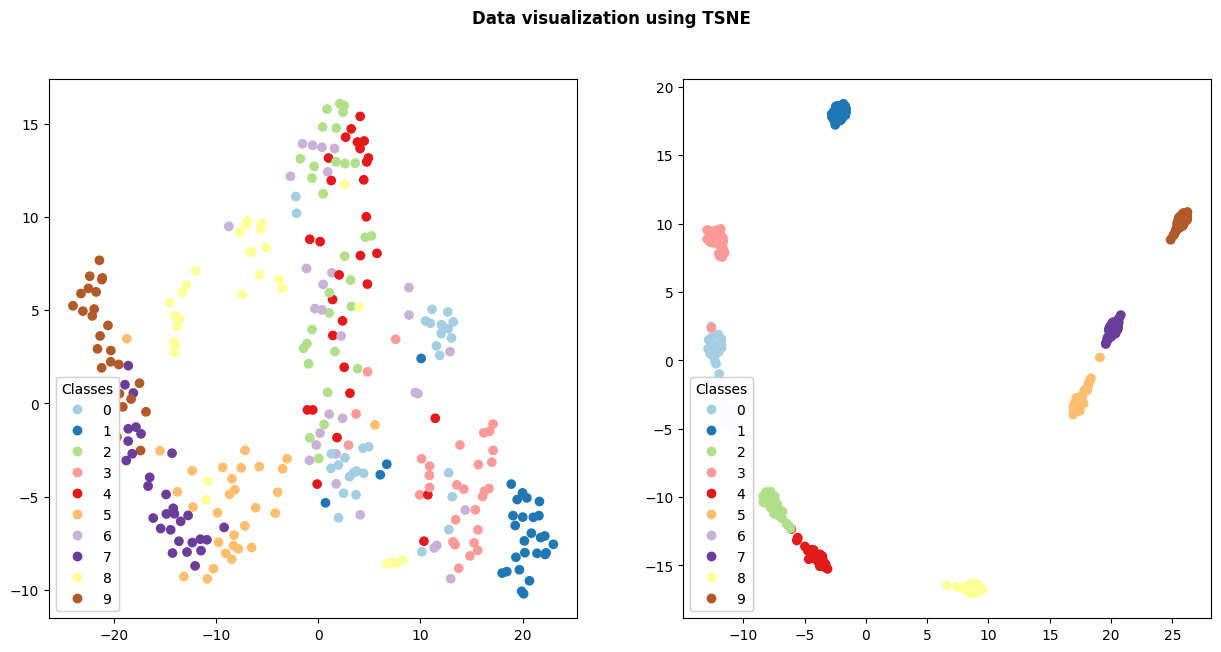

In [32]:
reduction_model = TSNE(n_components=2, perplexity=30, random_state=42)
reduction_model_embedding = TSNE(n_components=2, perplexity=30, random_state=42)

vis_x = reduction_model.fit_transform(t.get_flatten(), t.target)
vis_x_embed = reduction_model_embedding.fit_transform(embedding_data)

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7)
fig.suptitle("Data visualization using TSNE", weight="bold")
sc0 = ax[0].scatter(vis_x[:,0], vis_x[:,1], c=t.target, cmap='Paired')
sc1 = ax[1].scatter(vis_x_embed[:,0], vis_x_embed[:,1], c=t.target, cmap="Paired")

legend1 = ax[1].legend(*sc1.legend_elements(),
                    loc="lower left", title="Classes")
ax[1].add_artist(legend1)

legend2 = ax[0].legend(*sc0.legend_elements(),
                    loc="lower left", title="Classes")
ax[0].add_artist(legend2)

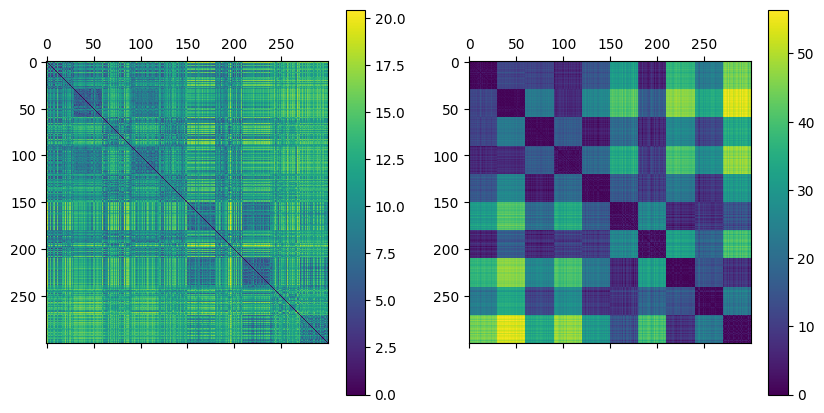

In [33]:
baseline_distance = metrics.pairwise_distances(t.get_flatten())
learned_distance = metrics.pairwise_distances(embedding_data)

order = t.target.argsort()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,5)
c = axs[0].matshow(baseline_distance[order, :][:, order])
c2 = axs[1].matshow(learned_distance[order, :][:, order])
fig.colorbar(c)
fig.colorbar(c2)


In [34]:
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average", metric="precomputed")
quantum_prediction = quantum_clustering.fit_predict(learned_distance)
evaluate_clustering(embedding_data, quantum_prediction, t.target)

Silhouette:    0.634
Purity:        0.893


In [35]:
quantum_clustering = KMeans(n_clusters=10,  init='k-means++', n_init=10)
quantum_prediction = quantum_clustering.fit_predict(embedding_data)
evaluate_clustering(embedding_data, quantum_prediction, t.target)

Silhouette:    0.680
Purity:        0.977


In [19]:

training_dataloader = DataLoader(t, batch_size=10, shuffle=False)

with torch.no_grad():
    distance_model.eval()
    clustering_data = np.empty((0,2))
    for anchor, _,_ in tqdm(training_dataloader):
        x = anchor.to(device)
        x = distance_model.conv_1(x)
        x = distance_model.conv_2(x)
        x = distance_model.conv_3(x)
        x = distance_model.flatten(x)
        x = distance_model.reduction(x)
        clustering_data = np.concatenate((clustering_data,x.to("cpu").squeeze(0).numpy()), axis=0)

clustering_data

  0%|          | 0/30 [00:00<?, ?it/s]


AttributeError: 'TripletNet' object has no attribute 'conv_1'

In [ ]:
from qiskit import ClassicalRegister
from qiskit.providers.basic_provider import BasicProvider
from qiskit import transpile
from qiskit.visualization import plot_histogram

quantum_w = distance_model.q1.weight.detach().to("cpu").numpy()
qemb_circuit = distance_model.q1.neural_network.circuit

def quantum_embedding_distance(x,y):

    base = QuantumRegister(8, "data")
    ancilla = QuantumRegister(1, 'ancilla')
    classical = ClassicalRegister(1, 'output')
    swap_circuit = QuantumCircuit(base, ancilla, classical)

    w1 = np.append(x, quantum_w)
    w2 = np.append(y, quantum_w)

    q1 = qemb_circuit.assign_parameters(w1)
    q2 = qemb_circuit.assign_parameters(w2)

    swap_circuit = swap_circuit.compose(q1, [0,1,2,3])
    swap_circuit = swap_circuit.compose(q2, [4,5,6,7])

    swap_circuit.barrier()

    swap_circuit.h(ancilla)
    swap_circuit.cswap(ancilla, 0,4)
    swap_circuit.cswap(ancilla, 1,5)
    swap_circuit.cswap(ancilla, 2,6)
    swap_circuit.cswap(ancilla, 3,7)
    swap_circuit.h(ancilla)
    swap_circuit.measure(ancilla,classical)

    backend = BasicProvider().get_backend('basic_simulator')
    qc = transpile(swap_circuit, backend)
    result = backend.run(qc, shots=1000).result().get_counts(qc).get('1',0)

    ret = result
    return ret


quantum_embedding_distance(clustering_data[16], clustering_data[8])

In [ ]:
from sklearn.metrics import pairwise_distances
val = 1000

angles_matrix = np.zeros((val, val))

cd = clustering_data[:val]

for i in tqdm(range(val)):
    for j in range(i):
        angles_matrix[i,j] = quantum_embedding_distance(cd[i], cd[j])
        angles_matrix[j,i] = angles_matrix[i,j]




In [ ]:
order = t.target[:val].argsort()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,5)
c = axs[0].matshow(metrics.pairwise_distances(embedding_data[:val])[order, :][:, order])
c2 = axs[1].matshow(angles_matrix[order, :][:, order])
fig.colorbar(c)
fig.colorbar(c2)

In [ ]:
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average", metric="precomputed")
quantum_prediction = quantum_clustering.fit_predict(angles_matrix)
evaluate_clustering(embedding_data[:val], quantum_prediction, t.target[:val])

### Test evaluation

In [36]:
t_test = TripletImageDataset(X_test, y_test, 10, transforms.ToTensor())
t_test_loader = DataLoader(t_test, batch_size=128, shuffle=False)

In [37]:
test_embedding_data = embed(distance_model, t_test_loader, 16, device)


100%|██████████| 79/79 [00:01<00:00, 67.83it/s]


In [38]:
reduction_model = TSNE(n_components=2, perplexity=30, random_state=129)
reduction_model_embedding = TSNE(n_components=2, perplexity=30, random_state=129)

vis_x = reduction_model.fit_transform(t_test.get_flatten())
vis_x_embed = reduction_model_embedding.fit_transform(test_embedding_data)

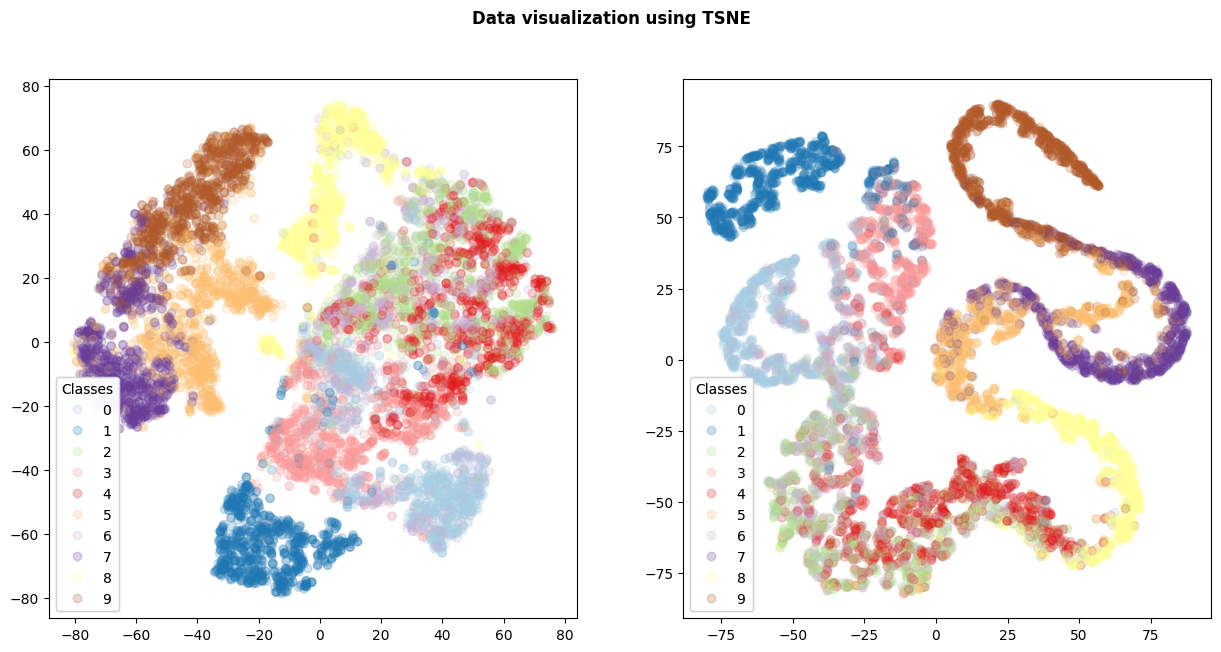

In [39]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7)
fig.suptitle("Data visualization using TSNE", weight="bold")
sc0 = ax[0].scatter(vis_x[:,0], vis_x[:,1], c=t_test.target, cmap='Paired', alpha=0.2)
sc1 = ax[1].scatter(vis_x_embed[:,0], vis_x_embed[:,1], c=t_test.target, cmap="Paired",  alpha=0.2)

legend1 = ax[1].legend(*sc1.legend_elements(),
                    loc="lower left", title="Classes")
ax[1].add_artist(legend1)

legend2 = ax[0].legend(*sc0.legend_elements(),
                    loc="lower left", title="Classes")
ax[0].add_artist(legend2)

NameError: name 'quantum_prediction1' is not defined

<Figure size 4500x2100 with 0 Axes>

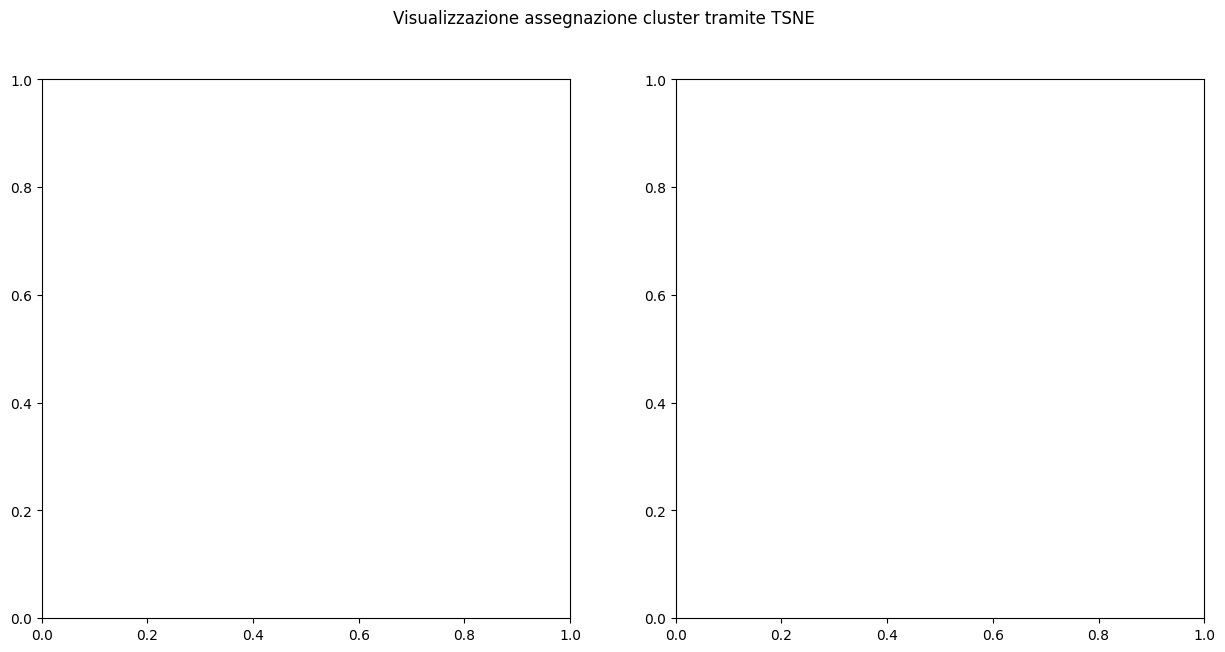

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

figure(figsize=(15, 7), dpi=300)

vals = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"}


labels = [vals[i] for i in t_test.target]



fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,7)

fig.suptitle("Visualizzazione assegnazione cluster tramite TSNE")

for i in range(10):
    ix = np.where(quantum_prediction1 == i)
    ax[0].scatter(vis_x_embed[ix,0], vis_x_embed[ix,1],label=str(i), cmap='Paired')

    ix = np.where(quantum_prediction2 == i)
    ax[1].scatter(vis_x_embed[ix,0], vis_x_embed[ix,1], label=str(i) , cmap="Paired")
    


ax[0].set_title("QuantumTripletLoss + Agglomeartive (Euclidean)")
ax[1].set_title("QuantumTripletLoss + KMeans")

ax[1].legend(loc="lower right", title="Classes")
ax[0].legend(loc="lower right", title="Classes")

In [40]:
print("QUANTUM")
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average")
quantum_prediction1 = quantum_clustering.fit_predict(test_embedding_data)
evaluate_clustering(test_embedding_data, quantum_prediction1, t_test.target)

print("")

print("TSNE")
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="average")
quantum_prediction1 = quantum_clustering.fit_predict(vis_x)
evaluate_clustering(vis_x, quantum_prediction1, t_test.target)

QUANTUM
Silhouette:    0.506
Purity:        0.603

TSNE
Silhouette:    0.399
Purity:        0.590


In [41]:

print("QUANTUM")
quantum_clustering = KMeans(n_clusters=10, init="k-means++",n_init=10)
quantum_prediction2 = quantum_clustering.fit_predict(test_embedding_data)
evaluate_clustering(test_embedding_data, quantum_prediction2, t_test.target)

print("")


print("TSNE")
quantum_clustering = KMeans(n_clusters=10, init="k-means++",n_init=10)
quantum_prediction2 = quantum_clustering.fit_predict(vis_x)
evaluate_clustering(vis_x, quantum_prediction2, t_test.target)



QUANTUM
Silhouette:    0.528
Purity:        0.661

TSNE
Silhouette:    0.418
Purity:        0.598


In [ ]:
x = vis_x_embed[:,0]
y = vis_x_embed[:,1]
value = quantum_prediction1

xx,yy = np.meshgrid(x,y)
xx = xx.reshape(100*100)
yy = yy.reshape(100*100)
j = np.dstack((xx,yy,value))[0,:,:]

fig = plt.figure(figsize =(12,4))
ax1 = plt.subplot(121)
xi,yi = np.meshgrid(x,y)
va    = value.reshape(100,100)
pc = plt.pcolormesh(xi,yi,va,cmap = plt.cm.Spectral)
plt.colorbar(pc)

ax2 = plt.subplot(122)
y_pred = KMeans(n_clusters=12, random_state=43).fit_predict(j)
vb = y_pred.reshape(100,100)
plt.pcolormesh(xi,yi,vb,cmap = plt.cm.Accent)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

n_clusters = 10
fig, ax1,  = plt.subplots(1, 1)
fig.set_size_inches(7, 8)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
X = test_embedding_data
clusterer = AgglomerativeClustering(n_clusters=10, linkage="average")
cluster_labels = clusterer.fit_predict(test_embedding_data)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.terrain(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Curva Silhouette QuantumTripletLoss + Agglomerative (Euclidean) su FashionMNIST")
ax1.set_xlabel("Valori Silhouette per campione")
ax1.set_ylabel("Clusters")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris
from matplotlib.pyplot import figure

def rgb_hex(color):
    '''converts a (r,g,b) color (either 0-1 or 0-255) to its hex representation.
    for ambiguous pure combinations of 0s and 1s e,g, (0,0,1), (1/1/1) is assumed.'''
    message='color must be an iterable of length 3.'
    assert hasattr(color, '__iter__'), message
    assert len(color)==3, message
    if all([(c<=1)&(c>=0) for c in color]): color=[int(round(c*255)) for c in color] # in case provided rgb is 0-1
    color=tuple(color)
    return '#%02x%02x%02x' % color

def get_cluster_colors(n_clusters, my_set_of_20_rgb_colors, alpha=0.8, alpha_outliers=0.05):
    cluster_colors = my_set_of_20_rgb_colors
    cluster_colors = [c+[alpha] for c in cluster_colors]
    outlier_color = [0,0,0,alpha_outliers]
    return [cluster_colors[i%19] for i in range(n_clusters)] + [outlier_color]

def cluster_and_plot_dendrogram():

    model = AgglomerativeClustering(n_clusters=10, linkage="average",  compute_distances=True)
    labels = model.fit_predict(test_embedding_data)

    #model = AgglomerativeClustering(n_clusters=10, linkage="average", metric="euclidean", compute_distances=True)
    #labels = model.fit_predict(t_test.get_flatten())

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    predefined_colors = [
       [46, 139, 87],   [70, 130, 180],  [75, 0, 130],   [0, 139, 139],
        [245, 130, 48], [255, 69, 0], [255, 215, 0], [0, 0, 128],
         [128, 128, 128], [250, 190, 190], [0, 128, 128], [230, 190, 255],
        [170, 110, 40], [255, 250, 200], [128, 0, 0], [170, 255, 195],
        [128, 128, 0], [255, 215, 180], [0, 0, 128], [128, 128, 128]
    ]


    # perform hierarchical clustering
    Z              = linkage_matrix

    # get cluster labels
    labels_str     = [f"cluster #{l}: n={c}\n" for (l,c) in zip(*np.unique(labels, return_counts=True))]
    n_clusters     = len(labels_str)

    cluster_colors = [rgb_hex(c[:-1]) for c in get_cluster_colors(n_clusters, predefined_colors, alpha=0.8, alpha_outliers=0.05)]
    cluster_colors_array = [cluster_colors[l] for l in labels]
    link_cols = {}
    for i, i12 in enumerate(Z[:,:2].astype(int)):
        c1, c2 = (link_cols[x] if x > len(Z) else cluster_colors_array[x] for x in i12)
        link_cols[i+1+len(Z)] = c1 if c1 == c2 else 'k'

    # plot dendrogram with colored clusters
    fig = plt.figure(figsize=(10, 4), dpi=300)
    plt.title('Dendrogramma modello QuantumTripletLoss + Agglomerative (Euclidean) su FashionMNIST')
    plt.xlabel('Campioni')
    plt.ylabel('Distanza')

    t = 0

    # plot dendrogram based on clustering results
    dendrogram(
        Z,

        labels = labels,

        color_threshold=0,

        truncate_mode = 'level',
        p = 5,
        show_leaf_counts = True,
        leaf_rotation=90,
        leaf_font_size=10,
        show_contracted=False,
        link_color_func=lambda x: link_cols[x],
        distance_sort='descending',
        ax=plt.gca(),
        above_threshold_color="C0"
    )
    #plt.axhline(100, color='k')
    for i, s in enumerate(labels_str):
        plt.text(0.8, 0.95-i*0.04, s,
                transform=plt.gca().transAxes,
                va='top', color=cluster_colors[i])
    
    fig.patch.set_facecolor('white')
    return labels # 0 indexed

cluster_and_plot_dendrogram()


In [ ]:
test_dataloader = DataLoader(t_test, batch_size=10, shuffle=False)

clustering_data = np.empty((0,8))
with torch.no_grad():
    for anchor, _,_ in tqdm(test_dataloader):
        x = anchor.to(device)
        x = distance_model.conv_1(x)
        x = distance_model.conv_2(x)
        x = distance_model.conv_3(x)
        x = distance_model.flatten(x)
        x = distance_model.reduction(x)
        clustering_data = np.concatenate((clustering_data, x.to("cpu").squeeze(0).numpy()), axis=0)

X_train, _, y_train, _ = train_test_split(clustering_data, y_test, train_size=1000, stratify=y_test)

In [ ]:
from qiskit import ClassicalRegister
from qiskit.providers.basic_provider import BasicProvider
from qiskit import transpile
from qiskit.visualization import plot_histogram

quantum_w = distance_model.q1.weight.detach().to("cpu").numpy()
qemb_circuit = distance_model.q1.neural_network.circuit

base = QuantumRegister(8, "data")
ancilla = QuantumRegister(1, 'ancilla')
classical = ClassicalRegister(1, 'output')
swap_circuit = QuantumCircuit(base, ancilla, classical)

swap_register = QuantumCircuit(9,1)
swap_register.h(8)
swap_register.cswap(8, 0,4)
swap_register.cswap(8, 1,5)
swap_register.cswap(8, 2,6)
swap_register.cswap(8, 3,7)
swap_register.h(8)
swap_register.measure(8,0)



backend = BasicProvider().get_backend('basic_simulator')

In [ ]:
def quantum_embedding_distance(x,y):

    swap_model = swap_circuit.copy()
    w1 = np.append(x, quantum_w)
    w2 = np.append(y, quantum_w)

    q1 = qemb_circuit.assign_parameters(w1)
    q2 = qemb_circuit.assign_parameters(w2)

    swap_model = swap_model.compose(q1, [0,1,2,3])
    swap_model = swap_model.compose(q2, [4,5,6,7])

    swap_model.barrier()

    swap_model = swap_model.compose(swap_register)

    qc = transpile(swap_model, backend)
    result = backend.run(qc, shots=5000).result().get_counts(qc).get('1',0) 

    ret = result
    return ret

%timeit quantum_embedding_distance(X_train[1], X_train[5])

In [ ]:
from sklearn.metrics import pairwise_distances

swap_matrix = pairwise_distances(X_train, metric=quantum_embedding_distance)

In [ ]:
with open("SWAP_matix_FMNIST.data", "wb") as f:
    pickle.dump(swap_matrix, f)

In [ ]:
baseline_distance = metrics.pairwise_distances(t_test.get_flatten())
learned_distance = metrics.pairwise_distances(test_embedding_data)

#order = y_test.argsort()

mat = [
    [5,26,5],[48,3,6], [0,6,25]]


fig, axs = plt.subplots()
fig.set_size_inches(18, 7)

#c = axs.matshow(baseline_distance[order, :][:, order])
c = axs.matshow(mat, cmap="Greens")

for (i, j), z in np.ndenumerate(mat):
    axs.text(j, i, '{:d}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
#c = axs.matshow(swap_matrix[order, :][:, order], cmap="Accent")
axs.set_xticks([])
axs.set_yticks([])
fig.colorbar(c)


In [ ]:
quantum_clustering = AgglomerativeClustering(n_clusters=10, linkage="complete", metric="precomputed")
quantum_prediction = quantum_clustering.fit_predict(swap_matrix)
evaluate_clustering(X_train, quantum_prediction, y_train)

In [ ]:
from nltk.cluster import KMeansClusterer
import nltk

quantum_clustering = KMeansClusterer(num_means=10, distance=quantum_embedding_distance)

In [ ]:

quantum_prediction = quantum_clustering.cluster(clustering_data, assign_clusters=True)
evaluate_clustering(clustering_data, quantum_prediction, y_test)

In [ ]:
model = AgglomerativeClustering(n_clusters=10, metric=quantum_embedding_distance, linkage="average")
pred = model.fit_predict(clustering_data)

In [ ]:
baseline_distance = metrics.pairwise_distances(t_test.get_flatten())
learned_distance = metrics.pairwise_distances(test_embedding_data)

order = t_test.target.argsort()

fig, axs = plt.subplots()
fig.set_size_inches(18, 7)

c = axs.matshow(baseline_distance[order, :][:, order])
#c = axs.matshow(learned_distance[order, :][:, order])
#c = axs.matshow(angles_matrix[order, :][:, order])
axs.set_xticks([])
axs.set_yticks([])
fig.colorbar(c)
